# Forex Currencies Rates: GBP/USD - Median of Medians

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Initialization" data-toc-modified-id="Initialization-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Initialization</a></span></li><li><span><a href="#Hyper-Parameters-Search" data-toc-modified-id="Hyper-Parameters-Search-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Hyper Parameters Search</a></span></li><li><span><a href="#Training-and-Validation" data-toc-modified-id="Training-and-Validation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Training and Validation</a></span><ul class="toc-item"><li><span><a href="#Distributions-of-Validation-Errors" data-toc-modified-id="Distributions-of-Validation-Errors-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Distributions of Validation Errors</a></span></li><li><span><a href="#Visualization-of-Validation-Predictions" data-toc-modified-id="Visualization-of-Validation-Predictions-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Visualization of Validation Predictions</a></span></li></ul></li><li><span><a href="#Test-Predictions" data-toc-modified-id="Test-Predictions-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Test Predictions</a></span></li></ul></div>

## Initialization

In [1]:
# !pip install --use-feature=in-tree-build psutil requests pmdarima nb_black

In [2]:
# !pip install --use-feature=in-tree-build ../pytorch-fit/
# !pip install --use-feature=in-tree-build git+https://github.com/krzpiesiewicz/pytorch-fit

In [3]:
# !pip install --use-feature=in-tree-build ../timeseries/
# !pip install --use-feature=in-tree-build git+https://github.com/krzpiesiewicz/timeseries

In [4]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2
%aimport timeseries

<IPython.core.display.Javascript object>

In [5]:
import os
import IPython.display
from pprint import pprint
from datetime import datetime, timedelta
import numpy as np
import pandas as pd

import timeseries as tss
from timeseries.plotting import plot_ts, plot_hist

from utils.timeseries_data import ForexGBPUSDData
from utils.results import Results
from utils.plotting import (
    plot_model_test_prediction,
    plot_ground_truth,
    plot_hist_model_scores,
)
from scorings import get_comparison_scorings
from average_scoring import average_scores
from hyper_params import make_grid, grid_search_hyper_params
from models.median_of_medians import MedianOfMediansModel

<IPython.core.display.Javascript object>

In [6]:
import nb_black

from utils.notebook_init import notebook_init

notebook_init()

<IPython.core.display.Javascript object>

In [7]:
scorings = get_comparison_scorings()

ts_data = ForexGBPUSDData()
data_type = ts_data.data_type
data_name = ts_data.data_name

val_results = Results(data_type, data_name, "val")
test_results = Results(data_type, data_name, "test")

ts = ts_data.ts
train_intv = ts_data.train_interval
val_intv = ts_data.val_interval
test_intv = ts_data.test_interval
pred_steps = ts_data.pred_steps
pred_jump = ts_data.pred_jump

<IPython.core.display.Javascript object>

In [12]:
plot_ts(
    train_intv.view().iloc[: 60 * 5],
    engine="plotly",
    title="Forex Currencies Rates: GBP/USD",
)

<IPython.core.display.Javascript object>

## Hyper Parameters Search

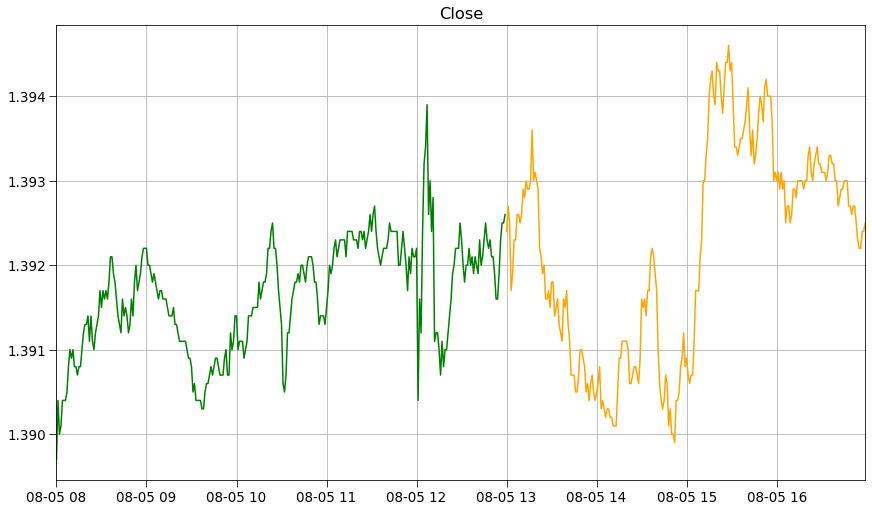

<IPython.core.display.Javascript object>

In [6]:
hyper_search_train_datetime = datetime(2021, 8, 5, 8)
hyper_search_val_datetime = datetime(2021, 8, 5, 13)
hyper_search_end_val_datetime = datetime(2021, 8, 5, 17)
hyper_search_train_intv = tss.Interval(
    ts, hyper_search_train_datetime, hyper_search_val_datetime
)
hyper_search_val_intv = tss.Interval(
    ts, hyper_search_val_datetime, hyper_search_end_val_datetime
)
fig = plot_ts(hyper_search_train_intv.view(), color="green")
display(plot_ts(hyper_search_val_intv.view(), fig=fig, color="orange"))

In [7]:
def median_of_medians_grid_search(scores=None):
    return grid_search_hyper_params(
        MedianOfMediansModel,
        grid,
        ts,
        hyper_search_train_intv,
        hyper_search_val_intv,
        best=10,
        score_params=score_params,
        scores=scores,
    )

<IPython.core.display.Javascript object>

In [8]:
group_size_range = np.arange(1, 10).tolist()
n_groups_range = np.arange(1, 10).tolist()
m_range = np.arange(1, 120).tolist()
grid = make_grid(n_groups=n_groups_range, group_size=group_size_range, m=m_range)
grid = [
    params
    for params in grid
    if params["n_groups"] * params["group_size"] * params["m"] <= 300
]

score_params = dict(
    scorings=["mae"],
    n_steps=pred_steps,
    n_steps_jump=10,
    mute=True,
)

<IPython.core.display.Javascript object>

In [9]:
%%time
pprint(median_of_medians_grid_search())

2132/2132, best_score: 0.001140, valuation: {'n_groups': 1, 'group_size': 7, 'm': 1}   
[(0.0011400925925925745, {'group_size': 7, 'm': 1, 'n_groups': 1}),
 (0.0011400925925925745, {'group_size': 1, 'm': 1, 'n_groups': 7}),
 (0.0011423148148147965, {'group_size': 5, 'm': 1, 'n_groups': 1}),
 (0.0011423148148147965, {'group_size': 1, 'm': 1, 'n_groups': 5}),
 (0.0011441666666666532, {'group_size': 2, 'm': 1, 'n_groups': 3}),
 (0.0011448148148147832, {'group_size': 6, 'm': 1, 'n_groups': 1}),
 (0.0011448148148147832, {'group_size': 1, 'm': 1, 'n_groups': 6}),
 (0.0011500925925925734, {'group_size': 3, 'm': 2, 'n_groups': 1}),
 (0.0011500925925925734, {'group_size': 1, 'm': 2, 'n_groups': 3}),
 (0.001154490740740731, {'group_size': 2, 'm': 1, 'n_groups': 4})]
CPU times: user 9min 21s, sys: 762 ms, total: 9min 22s
Wall time: 9min 22s


<IPython.core.display.Javascript object>

## Training and Validation

In [9]:
%%time
model = MedianOfMediansModel(n_groups=1, group_size=7)
model.fit(ts, train_intv)
val_mean_scores, val_all_scores, val_preds = average_scores(
    model,
    ts,
    val_intv,
    scorings=scorings,
    n_steps=pred_steps,
    n_steps_jump=pred_jump,
    return_all_scores=True,
    return_preds=True,
)
pprint(val_mean_scores)

model_name = "Median of Medians"
model_version = "(1,7)"
val_results.set_model(model_name, model_version)
val_results.add_model_scores(val_mean_scores)
val_results.add_model_preds(val_preds)

126/126 – RMSE: 0.00045, MAE: 0.00038, MASE: 7.13949, sMAPE: 0.02782, elapsed time: 4.3s (last: 0.0s)      
{'MAE': 0.00038455026455026136,
 'MASE': 7.13948647995201,
 'RMSE': 0.000450294903648415,
 'sMAPE': 0.027817203369771865}
CPU times: user 3.98 s, sys: 100 ms, total: 4.08 s
Wall time: 4.76 s


<IPython.core.display.Javascript object>

### Distributions of Validation Errors

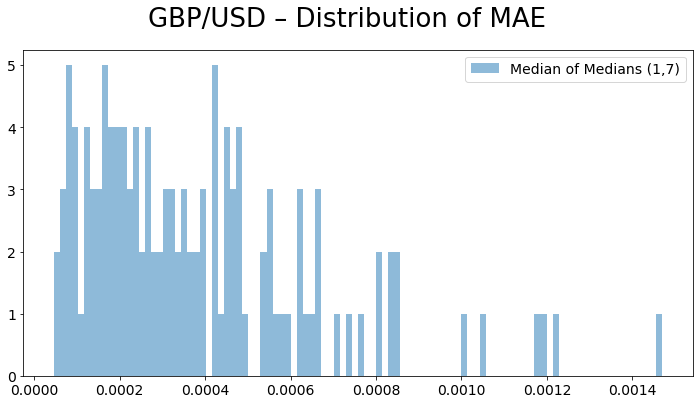

<IPython.core.display.Javascript object>

In [10]:
scoring_name = "MAE"
display(
    plot_hist_model_scores(
        data_name,
        val_all_scores,
        scoring_name,
        model_name=model_name,
        model_version=model_version,
        in_label=True,
    )
)

### Visualization of Validation Predictions

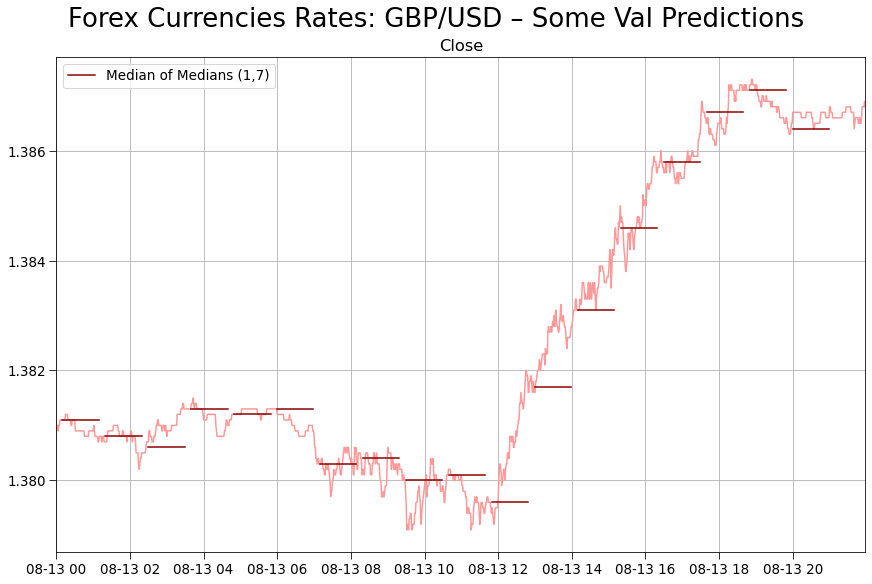

<IPython.core.display.Javascript object>

In [12]:
fig_time_delta = timedelta(minutes=10)
fig = plot_ground_truth(
    val_intv,
    mode="val",
    data_type=data_type,
    data_name=data_name,
)
display(
    plot_model_test_prediction(
        val_intv,
        fig_time_delta,
        val_preds,
        model_name=model_name,
        model_version=model_version,
        fig=fig,
    )
)

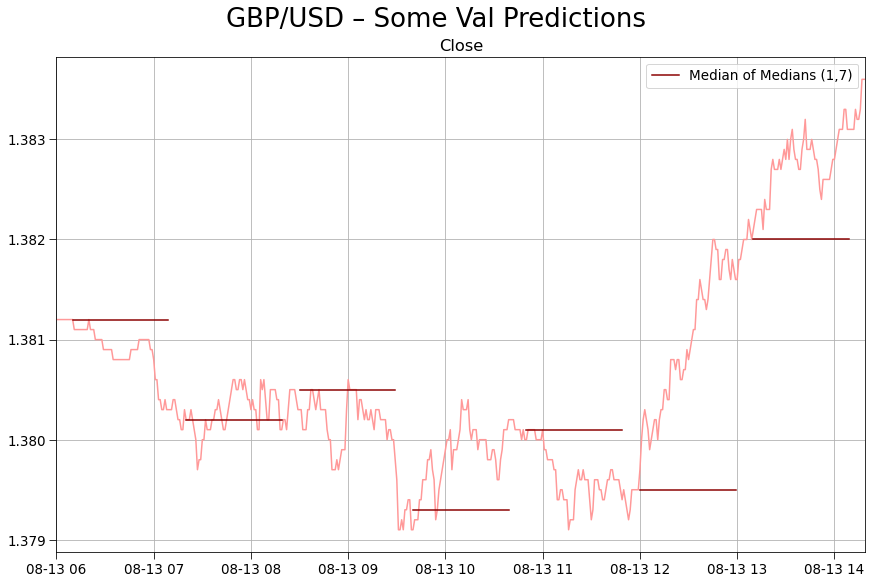

<IPython.core.display.Javascript object>

In [13]:
short_val_intv = tss.Interval(
    ts, datetime(2021, 8, 13, 6), datetime(2021, 8, 13, 14, 20)
)
fig = plot_ground_truth(short_val_intv, mode="val", data_name=data_name)
display(
    plot_model_test_prediction(
        short_val_intv,
        fig_time_delta,
        val_preds,
        model_name=model_name,
        model_version=model_version,
        fig=fig,
    )
)

## Test Predictions

In [14]:
%%time
model.update(ts, val_intv)
test_mean_scores, test_all_scores, test_preds = average_scores(
    model,
    ts,
    test_intv,
    scorings=scorings,
    n_steps=pred_steps,
    n_steps_jump=pred_jump,
    return_all_scores=True,
    return_preds=True,
)
pprint(test_mean_scores)
test_results.set_model(model_name, model_version)
test_results.add_model_scores(test_all_scores, test_mean_scores)
test_results.add_model_preds(test_preds)

144/144 – RMSE: 0.00050, MAE: 0.00043, MASE: 6.81797, sMAPE: 0.03137, elapsed time: 5.0s (last: 0.0s)      
{'MAE': 0.0004345370370370476,
 'MASE': 6.817965415451935,
 'RMSE': 0.0005022112109667571,
 'sMAPE': 0.0313679811124652}
CPU times: user 4.62 s, sys: 68.4 ms, total: 4.69 s
Wall time: 5.58 s


<IPython.core.display.Javascript object>